# Performance Report

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
from deepchecks.vision.base import VisionData
from torchvision import models
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import copy

In [3]:
from deepchecks.vision.checks.performance import PerformanceReport

## Loading data and model:

In [4]:
from deepchecks.vision.datasets.classification import mnist

In [5]:
def simple_nn():
    torch.manual_seed(42)

    # Define model
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 10)
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits

    model = NeuralNetwork().to('cpu')
    return model

def trained_mnist(simple_nn, mnist_data_loader_train):
    torch.manual_seed(42)
    simple_nn = copy.deepcopy(simple_nn)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(simple_nn.parameters(), lr=1e-3)
    size = len(mnist_data_loader_train.dataset)
    # Training 1 epoch
    simple_nn.train()
    for batch, (X, y) in enumerate(mnist_data_loader_train):
        X, y = X.to('cpu'), y.to('cpu')

        # Compute prediction error
        pred = simple_nn(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return simple_nn

In [6]:
train_ds = mnist.load_dataset(train=True, object_type='Dataset')
test_ds = mnist.load_dataset(train=False, object_type='Dataset')

In [7]:
model = trained_mnist(simple_nn(), train_ds.get_data_loader())

loss: 2.287713  [    0/60000]
loss: 2.271768  [ 6400/60000]
loss: 2.227654  [12800/60000]
loss: 2.213990  [19200/60000]
loss: 2.159032  [25600/60000]
loss: 2.118144  [32000/60000]
loss: 2.020084  [38400/60000]
loss: 1.975659  [44800/60000]
loss: 1.823154  [51200/60000]
loss: 1.817344  [57600/60000]


## Running peformance report on classification

Performance Report Summarize given metrics on a dataset and model. Read More... Additional Outputs

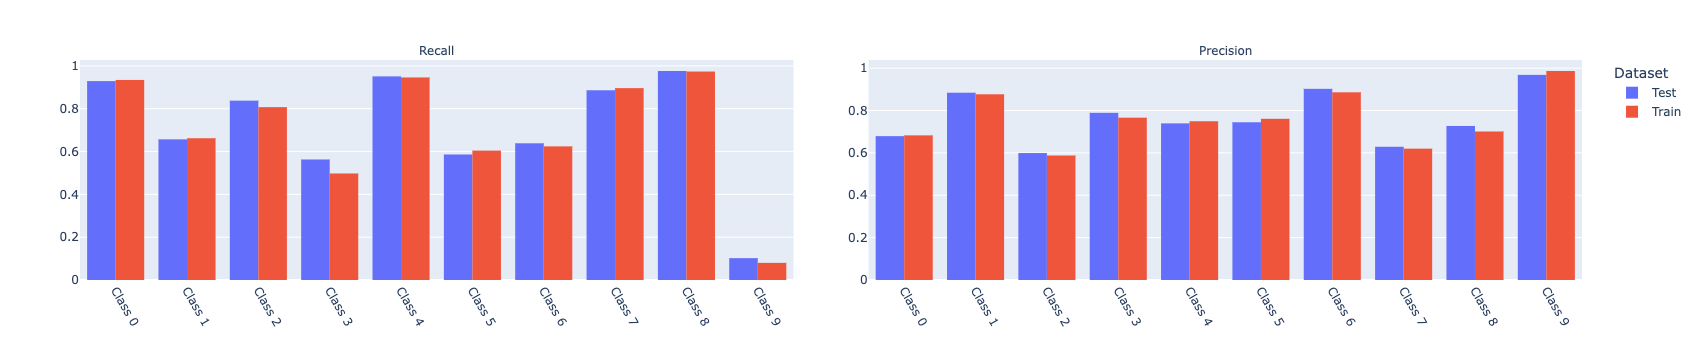

In [8]:
from deepchecks.vision.utils.classification_formatters import ClassificationPredictionFormatter
check = PerformanceReport(prediction_formatter=ClassificationPredictionFormatter(nn.Softmax(dim=1)))
check.run(train_ds, test_ds, model)

# Performance report object detection

In [9]:
import numpy as np
from deepchecks.vision.utils.detection_formatters import DetectionLabelFormatter, DetectionPredictionFormatter
from deepchecks.vision.datasets.detection import coco


In [10]:
yolo = coco.load_model(pretrained=True)

coco_train_loader = coco.load_dataset(train=True)
coco_test_loader = coco.load_dataset(train=False)

train_ds = VisionData(coco_train_loader, label_transformer=DetectionLabelFormatter(lambda x: x), num_classes=80)
test_ds = VisionData(coco_test_loader, label_transformer=DetectionLabelFormatter(lambda x: x), num_classes=80)

Using cache found in /home/yura/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-2-2 torch 1.10.2+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Using downloaded and verified file: /home/yura/Projects/deepchecks/deepchecks/deepchecks/vision/datasets/detection/coco128.zip
Extracting /home/yura/Projects/deepchecks/deepchecks/deepchecks/vision/datasets/detection/coco128.zip to /home/yura/Projects/deepchecks/deepchecks/deepchecks/vision/datasets/detection
Using downloaded and verified file: /home/yura/Projects/deepchecks/deepchecks/deepchecks/vision/datasets/detection/coco128.zip
Extracting /home/yura/Projects/deepchecks/deepchecks/deepchecks/vision/datasets/detection/coco128.zip to /home/yura/Projects/deepchecks/deepchecks/deepchecks/vision/datasets/detection


Engine run starting with max_epochs=1.
Epoch[1] Complete. Time taken: 00:00:24
Engine run complete. Time taken: 00:00:24
Engine run starting with max_epochs=1.
Epoch[1] Complete. Time taken: 00:00:25
Engine run complete. Time taken: 00:00:25


Performance Report Summarize given metrics on a dataset and model. Read More... Additional Outputs

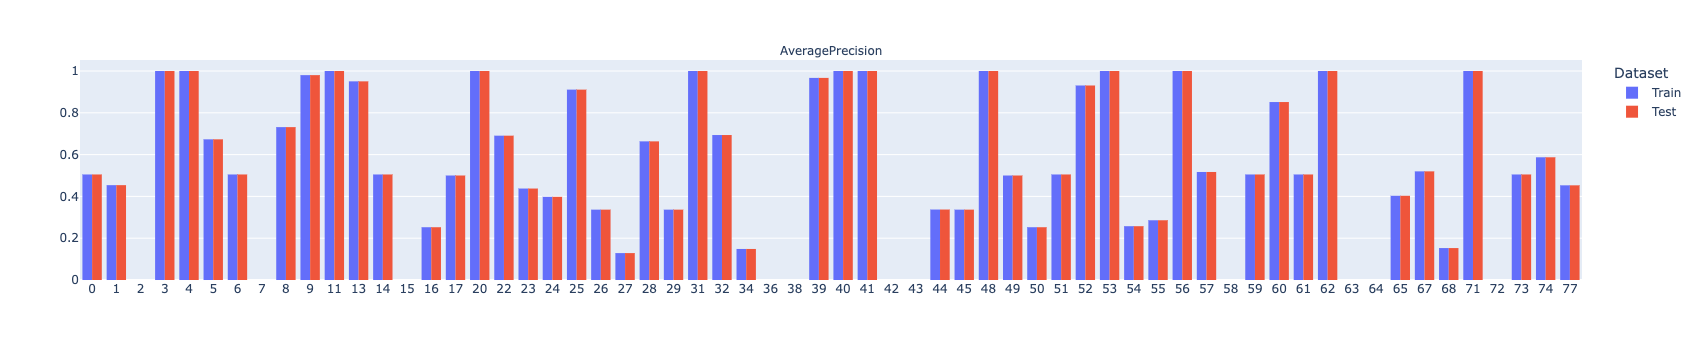

In [11]:
check = PerformanceReport(prediction_formatter=DetectionPredictionFormatter(coco.yolo_wrapper))
check.run(train_ds, train_ds, yolo)